In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os

In [3]:
# Load NASDAQ 100 data - Colab
# nasdaq100_data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/datasets/nasdaq100.pkl')

# Load NASDAQ 100 data - Local
nasdaq100_data = pd.read_pickle(r'C:\aiprojects\gbc-projects\DL1_Financial\AASD4010_project\data\data_pkls\nasdaq100.pkl')

Data Pre-Processing

In [4]:
# Extract relevant features for each company
features_df = pd.DataFrame()

# Loop through each company
for company in nasdaq100_data.columns.levels[0]:
    company_data = nasdaq100_data[company]

    # Calculate daily returns, volatility, and average return for each company
    daily_returns = company_data['Adj Close'].pct_change()
    volatility = daily_returns.rolling(window=20).std()
    average_return = daily_returns.rolling(window=20).mean()

    # Create a DataFrame with selected features for each company
    company_features = pd.DataFrame({
        f'{company}_Volatility': volatility,
        f'{company}_AverageReturn': average_return
    })

    features_df = pd.concat([features_df, company_features], axis=1)

train_df = features_df['2010':'2020']
train_df.head()

,AAPL_Volatility,AAPL_AverageReturn,ABNB_Volatility,ABNB_AverageReturn,ADBE_Volatility,ADBE_AverageReturn,ADI_Volatility,ADI_AverageReturn,ADP_Volatility,ADP_AverageReturn,...,WBA_Volatility,WBA_AverageReturn,WBD_Volatility,WBD_AverageReturn,WDAY_Volatility,WDAY_AverageReturn,XEL_Volatility,XEL_AverageReturn,ZS_Volatility,ZS_AverageReturn
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.017053,0.004419,NaN,NaN,0.013439,0.001577,0.007235,0.001647,0.007713,0.000007,...,0.013368,-0.000581,0.011084,-0.000868,NaN,NaN,0.008068,0.001362,NaN,NaN
2010-01-05,0.016378,0.005310,NaN,NaN,0.013574,0.001705,0.007225,0.001666,0.007295,-0.000841,...,0.013459,-0.001062,0.014176,0.001416,NaN,NaN,0.008435,0.001083,NaN,NaN
2010-01-06,0.015836,0.005645,NaN,NaN,0.013548,0.001777,0.007095,0.001832,0.007197,-0.001176,...,0.013514,-0.001203,0.014493,0.002033,NaN,NaN,0.008246,0.000742,NaN,NaN
2010-01-07,0.015924,0.005309,NaN,NaN,0.014207,0.001206,0.007144,0.001797,0.005744,-0.000219,...,0.013141,-0.000107,0.014055,0.002670,NaN,NaN,0.008320,0.000551,NaN,NaN
2010-01-08,0.013435,0.003553,NaN,NaN,0.014181,0.001253,0.007010,0.001638,0.005284,-0.000758,...,0.010932,-0.001590,0.013702,0.003355,NaN,NaN,0.008192,0.000238,NaN,NaN


In [5]:
train_df.isna().sum()

AAPL_Volatility          0
AAPL_AverageReturn       0
ABNB_Volatility       2769
ABNB_AverageReturn    2769
ADBE_Volatility          0
                      ... 
WDAY_AverageReturn     721
XEL_Volatility           0
XEL_AverageReturn        0
ZS_Volatility         2084
ZS_AverageReturn      2084
Length: 202, dtype: int64

In [6]:
def data_cleaning(df):
    # Dropping completely empty columns
    empty_columns = df.columns[df.isnull().all()]
    df = df.drop(empty_columns, axis=1)
    # Filling NaN values with mean
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(df)
    df_cleaned = imputer.transform(df)   
    return df_cleaned, empty_columns

train_df_cleaned, empty_columns = data_cleaning(train_df)
train_df_cleaned


array([[ 0.0170529 ,  0.00441925,  0.01343925, ...,  0.00136244,
         0.03734926,  0.00355724],
       [ 0.01637755,  0.00530985,  0.01357406, ...,  0.00108255,
         0.03734926,  0.00355724],
       [ 0.01583617,  0.00564479,  0.01354845, ...,  0.00074233,
         0.03734926,  0.00355724],
       ...,
       [ 0.01826059,  0.0064139 ,  0.01155899, ..., -0.0010617 ,
         0.06398174,  0.01374126],
       [ 0.01759979,  0.00444619,  0.01185441, ..., -0.00166531,
         0.06329081,  0.01592481],
       [ 0.01780738,  0.00391439,  0.01186689, ..., -0.00108578,
         0.0625466 ,  0.01713937]])

In [7]:
empty_columns = train_df.columns[train_df.isnull().all()]
if len(empty_columns) > 0:
    print(f"The following columns are completely empty: {', '.join(empty_columns)}")
    
    print("Empty columns dropped.")
else:
    print("No columns are completely empty.")


The following columns are completely empty: ABNB_Volatility, ABNB_AverageReturn, CEG_Volatility, CEG_AverageReturn, DASH_Volatility, DASH_AverageReturn, GEHC_Volatility, GEHC_AverageReturn, GFS_Volatility, GFS_AverageReturn
Empty columns dropped.


In [8]:
print(f"Missing cells: {sum(np.isnan(train_df_cleaned).flatten())}")

Missing cells: 0


In [9]:
# Autoencoder architecture
input_dim = train_df_cleaned.shape[1] # The number of columns in the training data which is 192
encoding_dim = 2  # Set the desired dimensionality of the embeddings

Approach_1: Dense network with 1 layer

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1 = tf.keras.Sequential([
    # Input Layer
    tf.keras.layers.InputLayer(input_shape=(input_dim,)),
    # Hidden Layer
    tf.keras.layers.Dense(encoding_dim, activation='tanh'),
    # Output Layer
    tf.keras.layers.Dense(input_dim, activation='tanh')
])

model_1.compile(optimizer=optimizer, loss='mse')

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [12]:
import shutil

# Specify the path to the 'logs' directory
log_dir = '.\\logs'

# Use shutil to remove the directory and its contents
shutil.rmtree(log_dir, ignore_errors=True)

In [13]:
# Train the autoencoder

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_1.fit(train_df_cleaned, train_df_cleaned, epochs=50, batch_size=32, shuffle=True, callbacks=[tensorboard_callback])

Epoch 1/50

87/87 [==============================] - 2s 4ms/step - loss: 7.6251e-05
Epoch 2/50
87/87 [==============================] - 0s 3ms/step - loss: 4.7408e-05
Epoch 3/50
87/87 [==============================] - 0s 2ms/step - loss: 3.9740e-05
Epoch 4/50
87/87 [==============================] - 0s 3ms/step - loss: 3.3140e-05
Epoch 5/50
87/87 [==============================] - 0s 3ms/step - loss: 3.1359e-05
Epoch 6/50
87/87 [==============================] - 0s 3ms/step - loss: 3.0802e-05
Epoch 7/50
87/87 [==============================] - 0s 3ms/step - loss: 3.0347e-05
Epoch 8/50
87/87 [==============================] - 0s 3ms/step - loss: 2.9915e-05
Epoch 9/50
87/87 [==============================] - 0s 3ms/step - loss: 2.9478e-05
Epoch 10/50
87/87 [==============================] - 0s 3ms/step - loss: 2.9132e-05
Epoch 11/50
87/87 [==============================] - 0s 3ms/step - loss: 2.8927e-05
Epoch 12/50
87/87 [==============================] - 0s 3ms/step - loss: 2.8834e-05


In [14]:
# Extract embeddings using the encoder
encoder = tf.keras.Model(inputs=model_1.input, outputs=model_1.layers[1].output)
embeddings = encoder.predict(train_df_cleaned)

87/87 [==============================] - 0s 2ms/step


In [15]:
# Apply K-means clustering to the embeddings
num_clusters = 3
kmeans = KMeans(n_init=10, n_clusters=num_clusters, random_state=42)
Clusters = kmeans.fit_predict(embeddings)

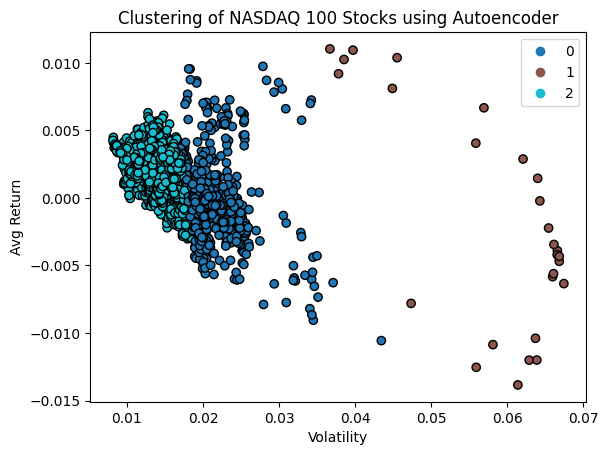

In [17]:
cluster_colors = {0: 'red', 1: 'green', 2: 'blue' }

scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=Clusters, cmap='tab10', edgecolors='black')
plt.xlabel('Volatility')
plt.ylabel('Avg Return')
plt.title('Clustering of NASDAQ 100 Stocks using Autoencoder')

plt.legend(handles=scatter.legend_elements()[0], labels=cluster_colors.keys())

plt.show()


Approach_2: Stacked Autoencoder

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_dim,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(encoding_dim, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(input_dim, activation='tanh')
])

model_2.compile(optimizer=optimizer, loss='mse')

In [19]:
import shutil

# Specify the path to the 'logs' directory
log_dir_2 = '.\\logs_2'

# Use shutil to remove the directory and its contents
shutil.rmtree(log_dir_2, ignore_errors=True)

In [20]:
# Train the autoencoder

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_2, histogram_freq=1)

model_2.fit(train_df_cleaned, train_df_cleaned, epochs=50, batch_size=32, shuffle=True, callbacks=[tensorboard_callback])

Epoch 1/50
87/87 [==============================] - 1s 5ms/step - loss: 6.8236e-05
Epoch 2/50
87/87 [==============================] - 1s 6ms/step - loss: 3.3340e-05
Epoch 3/50
87/87 [==============================] - 0s 6ms/step - loss: 3.1398e-05
Epoch 4/50
87/87 [==============================] - 1s 7ms/step - loss: 3.0164e-05
Epoch 5/50
87/87 [==============================] - 0s 6ms/step - loss: 2.9095e-05
Epoch 6/50
87/87 [==============================] - 1s 7ms/step - loss: 2.8801e-05
Epoch 7/50
87/87 [==============================] - 0s 6ms/step - loss: 2.8677e-05
Epoch 8/50
87/87 [==============================] - 1s 6ms/step - loss: 2.8706e-05
Epoch 9/50
87/87 [==============================] - 1s 6ms/step - loss: 2.8660e-05
Epoch 10/50
87/87 [==============================] - 1s 6ms/step - loss: 2.8636e-05
Epoch 11/50
87/87 [==============================] - 0s 5ms/step - loss: 2.8632e-05
Epoch 12/50
87/87 [==============================] - 0s 5ms/step - loss: 2.8620e-05
E

87/87 [==============================] - 1s 4ms/step


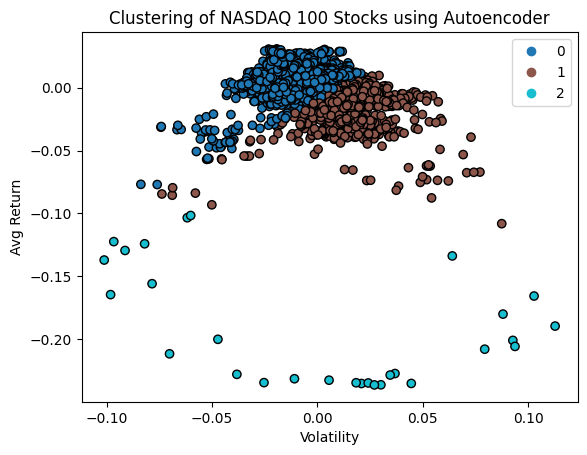

In [21]:
# Extract embeddings using the encoder
encoder_2 = tf.keras.Model(inputs=model_2.input, outputs=model_2.layers[1].output)
embeddings_2 = encoder_2.predict(train_df_cleaned)

# Apply K-means clustering to the embeddings
num_clusters = 3
kmeans = KMeans(n_init=10, n_clusters=num_clusters, random_state=42)
Clusters_2 = kmeans.fit_predict(embeddings_2)

scatter_2 = plt.scatter(embeddings_2[:, 0], embeddings_2[:, 1], c=Clusters_2, cmap='tab10', edgecolors='black')
plt.xlabel('Volatility')
plt.ylabel('Avg Return')
plt.title('Clustering of NASDAQ 100 Stocks using Autoencoder')

plt.legend(handles=scatter_2.legend_elements()[0], labels=cluster_colors.keys())

plt.show()

Visualization

In [1]:
# %tensorboard --logdir logs